# Chapter 6 - Notes

## Set Up

### Packages

In [1]:
import os

import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr
from numpy.polynomial import polynomial as poly
from scipy import stats
from scipy.special import expit, logit, logsumexp, softmax
from sklearn.preprocessing import StandardScaler

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Defaults

In [2]:
# seaborn defaults
sns.set(
    style="whitegrid",
    font_scale=1.2,
    rc={
        "axes.edgecolor": "0",
        "axes.grid.which": "both",
        "axes.labelcolor": "0",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "xtick.bottom": True,
        "ytick.left": True,
    },
)

colors = sns.color_palette()

### Constants

In [3]:
DATA_DIR = "../data"
HOWELL_FILE = "howell.csv"
CHERRY_BLOSSOMS_FILE = "cherry_blossoms.csv"
WAFFLE_DIVORCE_FILE = "waffle_divorce.csv"
MILK_FILE = "milk.csv"
CHIMPANZEES_FILE = "chimpanzees.csv"
ADMISSIONS_FILE = "ucbadmit.csv"
KLINE_FILE = "kline.csv"
REEDFROGS_FILE = "reedfrogs.csv"
CARS_FILE = "cars.csv"

RANDOM_SEED = 42

In [4]:
def load_data(file_name, data_dir=DATA_DIR, **kwargs):
    path = os.path.join(data_dir, file_name)
    return pd.read_csv(path, **kwargs)

Set seed

In [5]:
rng = np.random.default_rng(RANDOM_SEED)

## 6.1 Multicollinearity

### 6.1.1 Multicollinear legs

Simulate data with colinear predictors

In [6]:
N = 100

rng = np.random.default_rng(RANDOM_SEED)

height = rng.normal(loc=10, scale=2, size=N)
leg_prop = rng.uniform(low=0.4, high=0.5, size=N)
leg_left = leg_prop * height + rng.normal(loc=0, scale=0.02, size=N)
leg_right = leg_prop * height + rng.normal(loc=0, scale=0.02, size=N)

legs = pd.DataFrame(
    {
        "height": height,
        "leg_left": leg_left,
        "leg_right": leg_right,
    }
)

Now fit a model with both predictors

In [7]:
coords = {
    "obs_id": legs.index,
}
with pm.Model(coords_mutable=coords) as m6_1:
    # data
    leg_left = pm.MutableData("leg_left", legs.leg_left, dims="obs_id")
    leg_right = pm.MutableData("leg_right", legs.leg_right, dims="obs_id")

    # priors
    alpha = pm.Normal("alpha", mu=10, sigma=100)
    beta_l = pm.Normal("beta_l", mu=2, sigma=10)
    beta_r = pm.Normal("beta_r", mu=2, sigma=10)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic(
        "mu", alpha + beta_l * leg_left + beta_r * leg_right, dims="obs_id"
    )

    # likelihood
    height = pm.Normal(
        "height", mu=mu, sigma=sigma, observed=legs.height, dims="obs_id"
    )

    # fit
    trace_6_1 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_l, beta_r, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.


Look at the results

In [8]:
az.summary(
    trace_6_1,
    var_names=["~mu"],
    kind="stats",
    hdi_prob=0.89,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha,1.841,0.329,1.309,2.353
beta_l,1.794,1.977,-1.554,4.782
beta_r,0.011,1.973,-3.021,3.284
sigma,0.577,0.042,0.513,0.645


Note the extremely high standard deviation in the coefficients.

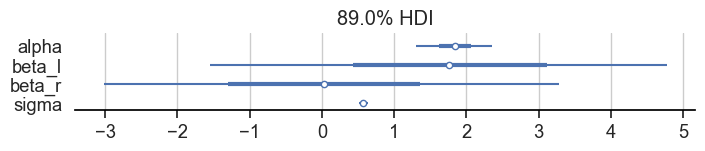

In [9]:
fig, ax = plt.subplots(figsize=(8, 1))

az.plot_forest(
    trace_6_1,
    var_names=["~mu"],
    combined=True,
    hdi_prob=0.89,
    ax=ax,
);

We can see more clearly what is going on by plotting the bivariate distribution of the coefficients and their sum.

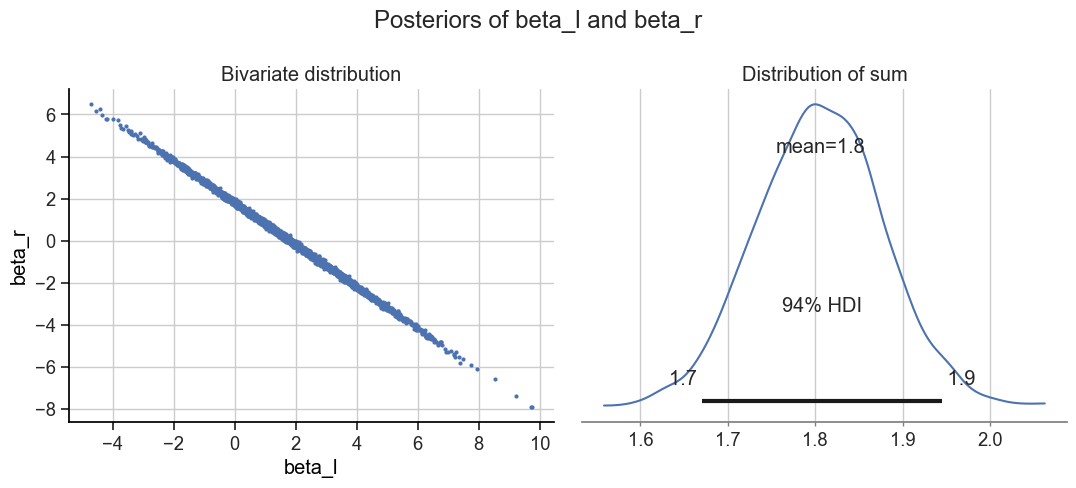

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(11, 5))

az.plot_pair(
    trace_6_1,
    var_names=["beta_l", "beta_r"],
    filter_vars="regex",
    # ax=np.array([axs[:1]]),
    ax=axs[0],
)

trace_6_1.posterior["beta_sum"] = (
    trace_6_1.posterior.beta_l + trace_6_1.posterior.beta_r
)
az.plot_posterior(
    trace_6_1,
    var_names="beta_sum",
    ax=axs[1],
)

axs[0].set(
    title="Bivariate distribution",
)
axs[1].set(
    title="Distribution of sum",
)

fig.suptitle("Posteriors of beta_l and beta_r")
fig.tight_layout();

Now fit a model on just left leg lengths.

In [11]:
coords = {
    "obs_id": legs.index,
}
with pm.Model(coords_mutable=coords) as m6_2:
    # data
    leg_left = pm.MutableData("leg_left", legs.leg_left, dims="obs_id")

    # priors
    alpha = pm.Normal("alpha", mu=10, sigma=100)
    beta_l = pm.Normal("beta_l", mu=2, sigma=10)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic("mu", alpha + beta_l * leg_left, dims="obs_id")

    # likelihood
    height = pm.Normal(
        "height", mu=mu, sigma=sigma, observed=legs.height, dims="obs_id"
    )

    # fit
    trace_6_2 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_l, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Look at the results

In [12]:
az.summary(
    trace_6_2,
    var_names=["~mu"],
    kind="stats",
    hdi_prob=0.89,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha,1.840,0.327,1.303,2.333
beta_l,1.806,0.072,1.694,1.920
sigma,0.575,0.041,0.509,0.637


That looks much more reasonable.

### 6.1.2 Multicollinear milk

Load the milk data

In [13]:
# load data
milk = load_data(MILK_FILE, delimiter=";")

# rename variables
milk.columns = milk.columns.str.replace(".", "_")

# standardise variables
cols = ["kcal_per_g", "perc_fat", "perc_lactose"]
milk_normaliser = StandardScaler()
milk_normaliser.fit(milk[cols])

milk_norm = pd.DataFrame(
    data=milk_normaliser.transform(milk[cols]),
    columns=cols,
)

Start with two univariate models

In [14]:
coords = {
    "obs_id": milk_norm.index,
}
with pm.Model(coords_mutable=coords) as m6_3:
    # data
    perc_fat = pm.MutableData("perc_fat", milk_norm.perc_fat, dims="obs_id")
    perc_lactose = pm.MutableData("perc_lactose", milk_norm.perc_lactose, dims="obs_id")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta_f = pm.Normal("beta_f", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic("mu", alpha + beta_f * perc_fat, dims="obs_id")

    # likelihood
    kcal_per_g = pm.Normal(
        "kcal_per_g", mu=mu, sigma=sigma, observed=milk_norm.kcal_per_g, dims="obs_id"
    )

    # sample
    trace_6_3 = pm.sample(random_seed=RANDOM_SEED)


with pm.Model(coords_mutable=coords) as m6_4:
    # data
    perc_fat = pm.MutableData("perc_fat", milk_norm.perc_fat, dims="obs_id")
    perc_lactose = pm.MutableData("perc_lactose", milk_norm.perc_lactose, dims="obs_id")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta_l = pm.Normal("beta_l", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic("mu", alpha + beta_l * perc_lactose, dims="obs_id")

    # likelihood
    kcal_per_g = pm.Normal(
        "kcal_per_g", mu=mu, sigma=sigma, observed=milk_norm.kcal_per_g, dims="obs_id"
    )

    # sample
    trace_6_4 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_f, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_l, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Look at the posteriors

In [15]:
pm.summary(
    trace_6_3,
    var_names=["~mu"],
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha,-0.00,0.08,-0.13,0.13
beta_f,0.86,0.09,0.71,1.00
sigma,0.50,0.07,0.39,0.60


In [16]:
pm.summary(
    trace_6_4,
    var_names=["~mu"],
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha,0.00,0.07,-0.11,0.12
beta_l,-0.90,0.08,-1.02,-0.78
sigma,0.42,0.06,0.33,0.51


Note that the two coefficients appear to be opposites.

Now fit a model with both predictors.

In [17]:
coords = {
    "obs_id": milk_norm.index,
}
with pm.Model(coords_mutable=coords) as m6_5:
    # data
    perc_fat = pm.MutableData("perc_fat", milk_norm.perc_fat, dims="obs_id")
    perc_lactose = pm.MutableData("perc_lactose", milk_norm.perc_lactose, dims="obs_id")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta_f = pm.Normal("beta_f", mu=0, sigma=0.5)
    beta_l = pm.Normal("beta_l", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic(
        "mu", alpha + beta_f * perc_fat + beta_l * perc_lactose, dims="obs_id"
    )

    # likelihood
    kcal_per_g = pm.Normal(
        "kcal_per_g", mu=mu, sigma=sigma, observed=milk_norm.kcal_per_g, dims="obs_id"
    )

    # sample
    trace_6_5 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_f, beta_l, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [18]:
pm.summary(
    trace_6_5,
    var_names=["~mu"],
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha,0.00,0.07,-0.11,0.13
beta_f,0.25,0.20,-0.05,0.58
beta_l,-0.67,0.20,-0.98,-0.34
sigma,0.42,0.06,0.33,0.51


We can understand what's happening by plotting the associations between the different variables

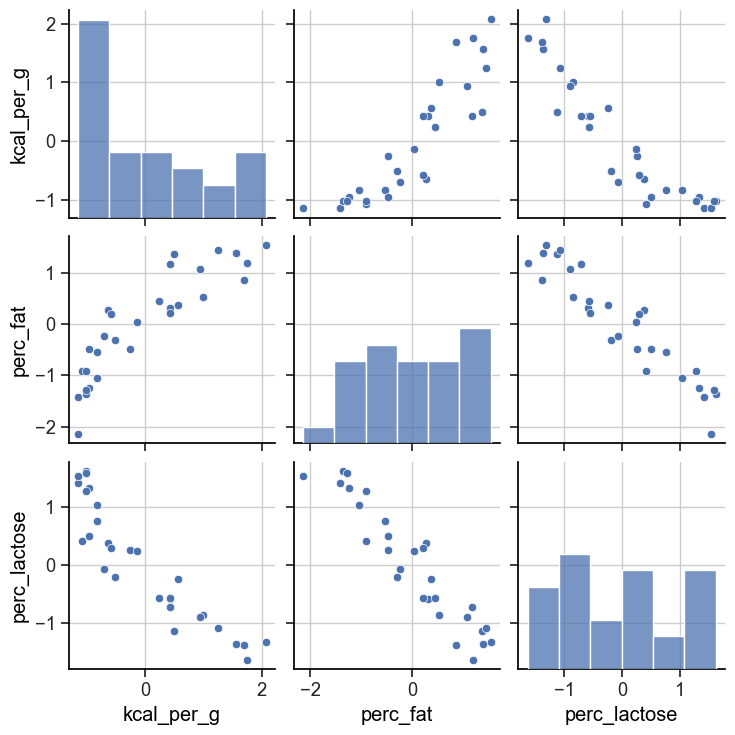

In [19]:
sns.pairplot(milk_norm);

The two predictors are strongly correlated with each other, but also strongly correlated with the target variable.

## 6.2 Post-treatment bias

Simulate the plant growth data

In [20]:
N = 100
rng = np.random.default_rng(RANDOM_SEED)

h0 = rng.normal(loc=10, scale=2, size=N)
treatment = np.concatenate([np.zeros(int(N / 2)), np.ones(int(N / 2))])
fungus = rng.binomial(n=1, p=0.5 - 0.4 * treatment, size=N)
h1 = h0 + rng.normal(loc=5 - 3 * fungus, scale=1, size=N)

plants = pd.DataFrame(
    {
        "h0": h0,
        "h1": h1,
        "treatment": treatment,
        "fungus": fungus,
    }
).astype(float)

### 6.2.1 A prior is born

Start with a simple model without using the predictor variable.

In [21]:
coords = {
    "obs_id": plants.index,
}
with pm.Model(coords_mutable=coords) as m6_6:
    # data
    h0 = pm.MutableData("h0", plants.h0, dims="obs_id")

    # priors
    p = pm.LogNormal("p", mu=0, sigma=0.25)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic("mu", h0 * p, dims="obs_id")

    # likelihood
    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=plants.h1, dims="obs_id")

    # sample
    trace_6_6 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [22]:
pm.summary(
    trace_6_6,
    var_names=["~mu"],
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%
p,1.40,0.02,1.37,1.43
sigma,1.82,0.13,1.61,2.01


Now let's include the predictors

In [23]:
coords = {
    "obs_id": plants.index,
}
with pm.Model(coords_mutable=coords) as m6_7:
    # data
    h0 = pm.MutableData("h0", plants.h0, dims="obs_id")
    treatment = pm.MutableData("treatment", plants.treatment, dims="obs_id")
    fungus = pm.MutableData("fungus", plants.fungus, dims="obs_id")

    # priors
    alpha = pm.LogNormal("alpha", mu=0, sigma=0.2)
    beta_t = pm.Normal("beta_t", mu=0, sigma=0.5)
    beta_f = pm.Normal("beta_f", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    p = pm.Deterministic(
        "p", alpha + beta_t * treatment + beta_f * fungus, dims="obs_id"
    )
    mu = pm.Deterministic("mu", h0 * p, dims="obs_id")

    # likelihood
    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=plants.h1, dims="obs_id")

    # sample
    trace_6_7 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_t, beta_f, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


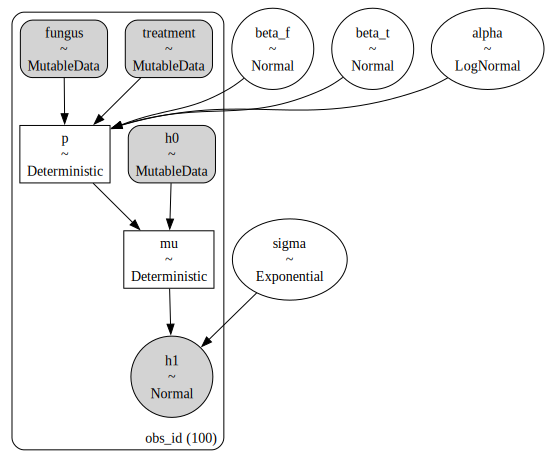

In [24]:
m6_7.to_graphviz()

In [25]:
pm.summary(
    trace_6_7,
    var_names=["~mu", "~p"],
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%
beta_t,0.04,0.03,0.01,0.09
beta_f,-0.28,0.03,-0.33,-0.24
alpha,1.47,0.02,1.44,1.50
sigma,1.14,0.08,1.00,1.26


Note that the value of $\alpha$ hasn't changed and the treatment effect appears to be basically zero.

### 6.2.2 Blocked by consequence

Now try removing fungus as a predictor

In [26]:
coords = {
    "obs_id": plants.index,
}
with pm.Model(coords_mutable=coords) as m6_8:
    # data
    h0 = pm.MutableData("h0", plants.h0, dims="obs_id")
    treatment = pm.MutableData("treatment", plants.treatment, dims="obs_id")
    fungus = pm.MutableData("fungus", plants.fungus, dims="obs_id")

    # priors
    alpha = pm.LogNormal("alpha", mu=0, sigma=0.2)
    beta_t = pm.Normal("beta_t", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    p = pm.Deterministic("p", alpha + beta_t * treatment, dims="obs_id")
    mu = pm.Deterministic("mu", h0 * p, dims="obs_id")

    # likelihood
    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=plants.h1, dims="obs_id")

    # sample
    trace_6_8 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_t, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [27]:
pm.summary(
    trace_6_8,
    var_names=["~mu", "~p"],
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%
beta_t,0.15,0.03,0.09,0.20
alpha,1.33,0.02,1.30,1.37
sigma,1.69,0.12,1.50,1.88


Now we properly capture the causal effect of the treatment.

### 6.2.3 Fungus and d-separation

Here's the DAG of the process

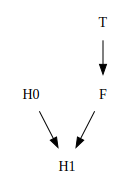

In [28]:
g = gr.Digraph("plant_growth", node_attr={"color": "white"})

g.node("H0")
g.node("H1")
g.node("T")
g.node("F")

g.edge("H0", "H1")
g.edge("F", "H1")
g.edge("T", "F")
g

What if we had moisture as an unobserved variable?

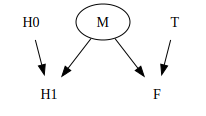

In [29]:
g = gr.Digraph("plant_growth", node_attr={"color": "white"})

g.node("H0")
g.node("H1")
g.node("M", color="black")
g.node("T")
g.node("F")

g.edge("H0", "H1")
g.edge("M", "H1")
g.edge("M", "F")
g.edge("T", "F")
g

## 6.3 Collider bias

### 6.3.1 Collider of false sorrow

Let's simulate happiness and marriage

In [30]:
def simulate_marriages(
    n_years, random_seed, p_marriage_intercept=-4, p_marriage_slope=1
):
    # set random seed
    rng = np.random.default_rng(random_seed)

    # defaults
    BIRTHS_PER_YEAR = 20
    MIN_MARRIAGE_AGE = 18
    MAX_MARRIAGE_AGE = 65

    # function for probability of marriage from happiness
    def prob_marriage(
        happiness, intercept=p_marriage_intercept, slope=p_marriage_slope
    ):
        return expit(intercept + slope * happiness)

    # run simulation
    people = pd.DataFrame(columns=["age", "happiness", "married"])
    for year in range(n_years):
        n_people = people.shape[0]

        # simulate people aging
        if n_people > 0:
            people["age"] = people["age"] + 1

            marriable_mask = (people["married"] == 0) & people["age"].between(
                MIN_MARRIAGE_AGE, MAX_MARRIAGE_AGE
            )
            people["married"] = np.where(
                marriable_mask,
                rng.binomial(
                    n=1,
                    p=prob_marriage(people.happiness),
                    size=n_people,
                ),
                people["married"],
            )

        # add new people
        new_people = pd.DataFrame(
            {
                "age": np.ones(BIRTHS_PER_YEAR),
                "happiness": rng.uniform(low=-2, high=2, size=BIRTHS_PER_YEAR),
                "married": np.zeros(BIRTHS_PER_YEAR),
            }
        )
        people = pd.concat([new_people, people], axis=0)

        # send people to spain
        people = people.loc[people["age"] <= MAX_MARRIAGE_AGE, :]

    return people

In [31]:
people = simulate_marriages(1_000, random_seed=RANDOM_SEED)

In [32]:
people.describe(percentiles=[]).round(2)

,age,happiness,married
count,1300.00,1300.00,1300.00
mean,33.00,-0.01,0.30
std,18.77,1.15,0.46
min,1.00,-2.00,0.00
50%,33.00,-0.02,0.00
max,65.00,1.99,1.00


Now plot the sampled data.

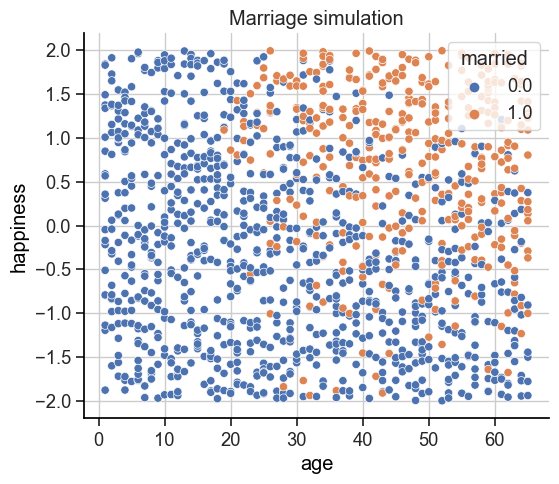

In [33]:
fig, ax = plt.subplots(figsize=(6, 5))

sns.scatterplot(
    people,
    x="age",
    y="happiness",
    hue="married",
    ax=ax,
)
ax.set(title="Marriage simulation");

Let's clean up the data before fitting the model

In [34]:
people

,age,happiness,married
0,1.0,0.311445,0.0
1,1.0,-1.877607,0.0
2,1.0,-1.194983,0.0
3,1.0,1.842046,0.0
4,1.0,-0.218311,0.0
...,...,...,...
15,65.0,1.224196,1.0
16,65.0,-1.001548,1.0
17,65.0,0.375359,0.0
18,65.0,0.054301,1.0


In [35]:
# restrict to adults
adults = people.loc[people["age"] >= 18, :].copy()
adults = adults.reset_index(drop=True)

# scale age
adults["age_scaled"] = (adults["age"] - 18) / (65 - 18)

Fit a model with both age and marriage as predictors

In [36]:
# create indicator variable
adults["married_idx"], married_vals = pd.factorize(adults["married"])

coords = {
    "obs_id": adults.index,
    "married": married_vals,
}
with pm.Model(coords_mutable=coords) as m6_9:
    # data
    age_scaled = pm.MutableData("age_scaled", adults.age_scaled, dims="obs_id")
    married_idx = pm.MutableData("married_idx", adults.married_idx, dims="obs_id")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=1, dims="married")
    beta_a = pm.Normal("beta_a", mu=0, sigma=2)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic("mu", alpha[married_idx] + beta_a * age_scaled, dims="obs_id")

    # likelihood
    happiness = pm.Normal(
        "happiness", mu=mu, sigma=sigma, observed=adults.happiness, dims="obs_id"
    )

    # sample
    trace_6_9 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


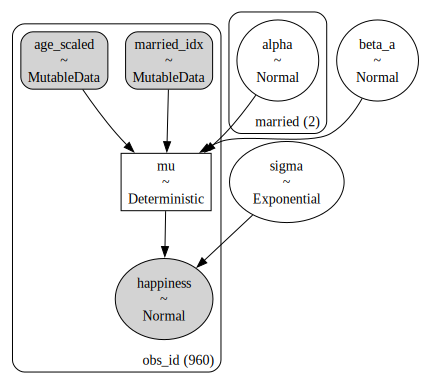

In [37]:
m6_9.to_graphviz()

In [38]:
az.summary(
    trace_6_9,
    var_names=["~mu"],
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha[0.0],-0.23,0.06,-0.33,-0.13
alpha[1.0],1.16,0.08,1.03,1.29
beta_a,-0.71,0.11,-0.87,-0.52
sigma,0.95,0.02,0.92,0.98


This implies a negative correlation between age and happiness; between age 18 and 65 we expect a drop in happiness of 0.7, or 18% of the total range.

Now let's try the same model without marriage status as a predictor.

In [39]:
# create indicator variable
adults["married_idx"], married_vals = pd.factorize(adults["married"])

coords = {
    "obs_id": adults.index,
    "married": married_vals,
}
with pm.Model(coords_mutable=coords) as m6_10:
    # data
    age_scaled = pm.MutableData("age_scaled", adults.age_scaled, dims="obs_id")
    married_idx = pm.MutableData("married_idx", adults.married_idx, dims="obs_id")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta_a = pm.Normal("beta_a", mu=0, sigma=2)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic("mu", alpha + beta_a * age_scaled, dims="obs_id")

    # likelihood
    happiness = pm.Normal(
        "happiness", mu=mu, sigma=sigma, observed=adults.happiness, dims="obs_id"
    )

    # sample
    trace_6_10 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_a, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


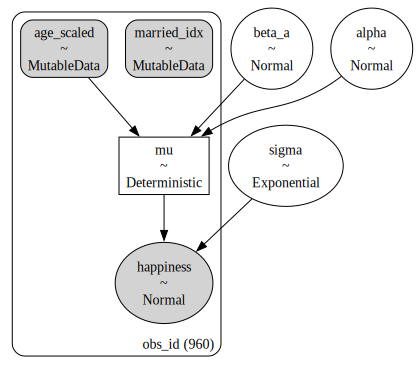

In [40]:
m6_10.to_graphviz()

In [41]:
az.summary(
    trace_6_10,
    var_names=["~mu"],
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha,0.00,0.07,-0.11,0.12
beta_a,-0.05,0.13,-0.24,0.16
sigma,1.15,0.03,1.11,1.19


Now there's essentially no association between the two.

### 6.3.2 The haunted DAG

First let's draw the DAG including the un-observed collider

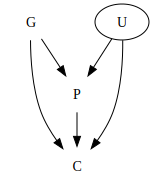

In [42]:
g = gr.Digraph("plant_growth", node_attr={"color": "white"})

g.node("G")
g.node("P")
g.node("C")
g.node("U", color="black")

g.edge("G", "P")
g.edge("G", "C")
g.edge("P", "C")
g.edge("U", "P")
g.edge("U", "C")
g

Now let's simulate the data

In [45]:
N = 200

b_GP = 1
b_GC = 0
b_PC = 1
b_U = 2

rng = np.random.default_rng(RANDOM_SEED)
U = 2 * rng.binomial(n=1, p=0.5, size=N) - 1
G = rng.normal(loc=0, scale=1, size=N)
P = rng.normal(loc=b_GP * G + b_U * U, scale=1, size=N)
C = rng.normal(loc=b_PC * P + b_U * U, scale=1, size=N)

education = pd.DataFrame({"G": G, "P": P, "U": U, "C": C}).astype(float)

First we regression C on G and P.

In [46]:
coords = {
    "obs_id": education.index,
}
with pm.Model(coords_mutable=coords) as m6_11:
    # data
    G = pm.MutableData("G", education.G, dims="obs_id")
    P = pm.MutableData("P", education.P, dims="obs_id")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta_PC = pm.Normal("beta_PC", mu=0, sigma=1)
    beta_GC = pm.Normal("beta_GC", mu=0, sigma=1)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic("mu", alpha + beta_PC * P + beta_GC * G, dims="obs_id")

    # likelihood
    C = pm.Normal("C", mu=mu, sigma=sigma, observed=education.C, dims="obs_id")

    # sample
    trace_6_11 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_PC, beta_GC, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


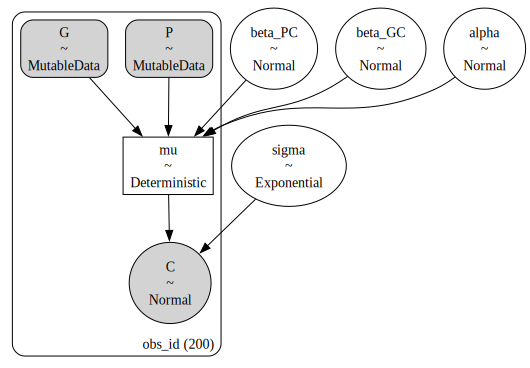

In [47]:
m6_11.to_graphviz()

In [48]:
az.summary(
    trace_6_11,
    var_names=["~mu"],
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha,-0.03,0.09,-0.17,0.12
beta_PC,1.81,0.04,1.75,1.88
beta_GC,-0.80,0.11,-0.97,-0.62
sigma,1.31,0.07,1.21,1.42


This is giving a very strong association between grandparents' education and children's education.

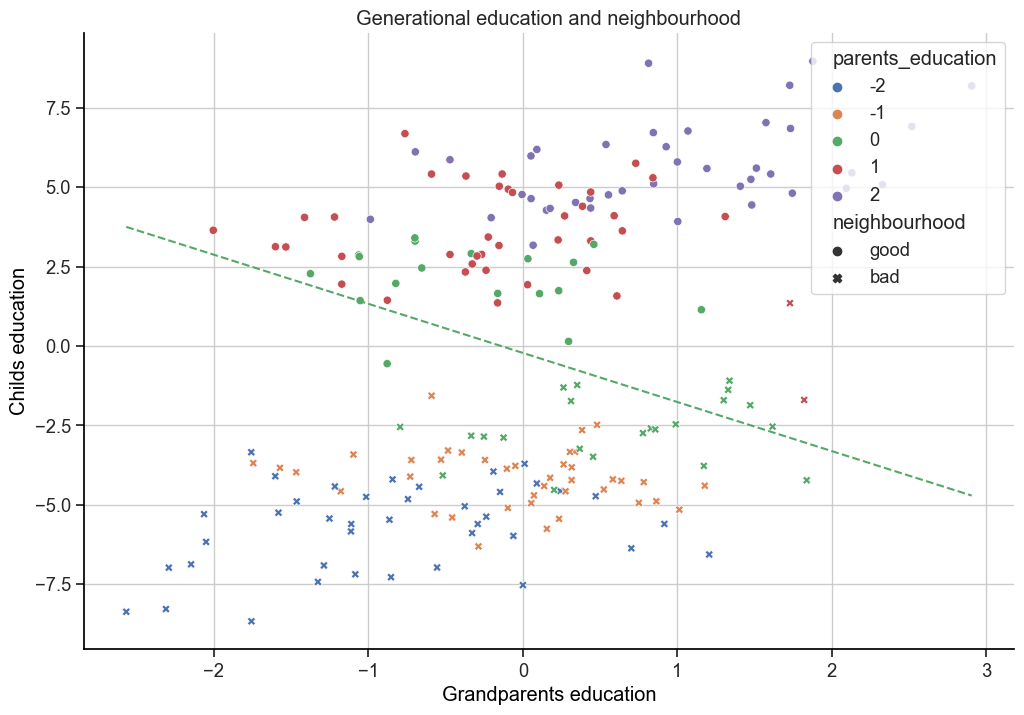

In [49]:
# map U-values to meaningful categories
education["neighbourhood"] = education["U"].map({-1.0: "bad", 1.0: "good"})

# bin parents education into quintiles labelled -2,.., 2
education["parents_education"] = pd.qcut(
    education["P"], 5, labels=np.arange(-2, 3), retbins=False
)

fig, ax = plt.subplots(figsize=(12, 8))

# plot data
sns.scatterplot(
    education,
    x="G",
    y="C",
    hue="parents_education",
    style="neighbourhood",
    ax=ax,
)

# fit linear regression for middle parents education
mid_parents_education_mask = education["parents_education"] == 0
lin_reg = poly.Polynomial.fit(
    education.loc[
        mid_parents_education_mask,
        "G",
    ],
    education.loc[
        mid_parents_education_mask,
        "C",
    ],
    deg=1,
)

# plot line
G_min = education["G"].min()
G_max = education["G"].max()
ax.plot(
    *lin_reg.linspace(n=100, domain=[G_min, G_max]),
    color=colors[2],
    ls="--",
)

ax.set(
    xlabel="Grandparents education",
    ylabel="Childs education",
    title="Generational education and neighbourhood",
);

This demonstrates what's actually going on; conditioning on parents education induces a negative correlation between grandparents' education and a children's education even though the association is otherwise positive, particularly if you correlate on neighbourhood.

Now let's refit the model including the unobserved collider U.

In [50]:
coords = {
    "obs_id": education.index,
}
with pm.Model(coords_mutable=coords) as m6_12:
    # data
    G = pm.MutableData("G", education.G, dims="obs_id")
    P = pm.MutableData("P", education.P, dims="obs_id")
    U = pm.MutableData("U", education.U, dims="obs_id")

    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta_PC = pm.Normal("beta_PC", mu=0, sigma=1)
    beta_GC = pm.Normal("beta_GC", mu=0, sigma=1)
    beta_U = pm.Normal("beta_U", mu=0, sigma=1)
    sigma = pm.Exponential("sigma", lam=1)

    # model
    mu = pm.Deterministic(
        "mu", alpha + beta_PC * P + beta_GC * G + beta_U * U, dims="obs_id"
    )

    # likelihood
    C = pm.Normal("C", mu=mu, sigma=sigma, observed=education.C, dims="obs_id")

    # sample
    trace_6_12 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_PC, beta_GC, beta_U, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [51]:
az.summary(
    trace_6_12,
    var_names=["~mu"],
    kind="stats",
    hdi_prob=0.89,
    round_to=2,
)

,mean,sd,hdi_5.5%,hdi_94.5%
alpha,-0.05,0.07,-0.17,0.06
beta_PC,1.11,0.07,0.99,1.22
beta_GC,-0.16,0.11,-0.31,0.03
beta_U,1.80,0.16,1.53,2.05
sigma,1.03,0.05,0.94,1.11


These are (approximately) the slopes we started with.